# Speech Recognition from Scratch
**TensorFlow** adaptation of [**DeepSpeech2**](https://arxiv.org/abs/1512.02595) automatic speech recognition fitted to be used with a [**KenLM**](https://kheafield.com/code/kenlm/) language model.

**Processing steps are:**
- data preparation (LibriSpeech: training set of 960 hours of "clean" and "other" speech & a seperate test set)
- character-tokenization
- conversion of audio to mel-spectrograms
- spectrogram augmentation
- tensorflow input pipeline
- recurrent neural network
- ctc-loss-function
- word-error-rate calculation
- inference optimized by a language model

In [ ]:
gpu = !nvidia-smi -L
print(gpu[0])
if "40GB" in gpu[0]:
    batch_size = 32 #64 #96
    print("!"*110)
else:
    batch_size = 256
batch_size

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-97ecca51-20fb-ab60-46c2-7d2407832ddc)


256

In [ ]:
import tensorflow as tf
tf.__version__
#2.8.2 working with tensorflow-io==0.25

'2.8.2'

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

DATA_PATH = '/content/drive/MyDrive/LibriSpeech/'
METADATA_PATH = DATA_PATH+'metadata/'
LM_MODEL_PATH = DATA_PATH+"kenlm-model/"

#DATA_PATH = 'G:/Meine Ablage/LibriSpeech/'
#METADATA_PATH = DATA_PATH+'metadata_local/'

MEDIA_PATH = DATA_PATH+'media/'
MODEL_PATH = DATA_PATH+'model/'
RECORDINGS_PATH = DATA_PATH+'my_recordings/'

Mounted at /content/drive


In [ ]:
#!pip install --upgrade tensorflow==2.8.2
!pip install jiwer
!pip install tensorflow-io==0.25
!pip install pyctcdecode
!pip install pypi-kenlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_io as tfio
from keras.utils.generic_utils import get_custom_objects
from jiwer import wer, cer
import IPython.display as ipd
import keras.backend as K
from IPython.display import Image
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import soundfile as sf
from datetime import datetime
from tqdm.auto import tqdm # auto for notebooks
import pytz
import os
from pyctcdecode import build_ctcdecoder
from time import time
import kenlm
from contextlib import redirect_stdout, redirect_stderr
import io, logging

In [ ]:
# Start an error log
now = datetime.now().strftime("%Y%m%d-%H%M%S")
logging.basicConfig(filename=f"{MODEL_PATH + now}_error.log", level=logging.DEBUG)

In [ ]:
data100 = pd.read_csv(METADATA_PATH+"metadata100_full.csv", sep="|", header=None, quoting=3)
data360 = pd.read_csv(METADATA_PATH+"metadata360_full.csv", sep="|", header=None, quoting=3)
data500 = pd.read_csv(METADATA_PATH+"metadata500_full.csv", sep="|", header=None, quoting=3)

In [ ]:
data = pd.concat([data100, data360, data500], ignore_index=True)
data.columns = ["file_path", "key", "transcription", "duration", "char_length", "speed"]
data.shape

(352547, 6)

In [ ]:
data.head(3)

,file_path,key,transcription,duration,char_length,speed
0,/content/drive/MyDrive/LibriSpeech/train-clean...,374-180298-0000,chapter sixteen i might have told you of the b...,14.530,178,12.250516
1,/content/drive/MyDrive/LibriSpeech/train-clean...,374-180298-0001,marguerite to be unable to live apart from me ...,16.085,214,13.304321
2,/content/drive/MyDrive/LibriSpeech/train-clean...,374-180298-0002,i wished above all not to leave myself time to...,13.295,169,12.711546


In [ ]:
data_test_clean = pd.read_csv(METADATA_PATH+"metadata_test_full.csv", sep="|", header=None, quoting=3)
data_test_clean.columns = ["file_path", "key", "transcription", "duration", "char_length", "speed"]

data_test_other = pd.read_csv(METADATA_PATH+"metadata_test-other_full.csv", sep="|", header=None, quoting=3)
data_test_other.columns = ["file_path", "key", "transcription", "duration", "char_length", "speed"]

In [ ]:
data_val = pd.concat([data_test_clean, data_test_other], ignore_index=True)
data_val.shape

(5559, 6)

### Duration

In [ ]:
fig = px.histogram(data, x="duration", marginal="box", nbins=500, template='plotly_dark',
                  title='Distribution of audio duration', height=400)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
min = 2
initial_size = data.shape[0]
data = data[data['duration'] >= min]
print(f'Percentage of data lost after removing samples with less than {min} seconds duration: '
     f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

Percentage of data lost after removing samples with less than 2 seconds duration: 0.2573%


In [ ]:
max = 17
initial_size = data.shape[0]
data = data[data['duration'] <= max]
print(f'Percentage of data lost after removing samples with more than {max} seconds duration: '
     f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

Percentage of data lost after removing samples with more than 17 seconds duration: 0.2127%


In [ ]:
fig = px.histogram(data, x="duration", marginal="box", nbins=500, template='plotly_dark', title='Distribution of confined audio duration', height=400)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data.shape

(350892, 6)

### Speed

In [ ]:
fig = px.histogram(data, x="speed", marginal="box", nbins=500, template='plotly_dark',
                  title='Distribution of audio speed', height=400)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
min = 9
initial_size = data.shape[0]
data = data[data['speed'] >= min]
print(f'Percentage of data lost after removing samples with less than {min} characters per second: '
     f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

Percentage of data lost after removing samples with less than 9 characters per second: 1.6310%


In [ ]:
max = 19.5
initial_size = data.shape[0]
data = data[data['speed'] <= max]
print(f'Percentage of data lost after removing samples with more than {max} characters per second: '
     f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')


Percentage of data lost after removing samples with more than 19.5 characters per second: 1.0760%


In [ ]:
fig = px.histogram(data, x="speed", marginal="box", nbins=500, template='plotly_dark', title='Distribution of confined audio speed', height=400)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data.shape

(341455, 6)

### Char_length

In [ ]:
fig = px.histogram(data, x="char_length", marginal="box", nbins=500, template='plotly_dark',
                   title='Distribution of transcription length', height=400)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
min = 25
initial_size = data.shape[0]
data = data[data['char_length'] >= min] 
print(f'Percentage of data lost after removing samples with less than {min} transcription length: '
      f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

Percentage of data lost after removing samples with less than 25 transcription length: 0.1757%


In [ ]:
max = 290
initial_size = data.shape[0]
data = data[data['char_length'] <= max]
print(f'Percentage of data lost after removing samples with more than {max} transcription length: '
      f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

Percentage of data lost after removing samples with more than 290 transcription length: 0.5542%


In [ ]:
fig = px.histogram(data, x="char_length", marginal="box", nbins=500, template='plotly_dark', title='Distribution of confined transcription length', height=400)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data.shape

(338966, 6)

In [ ]:
data['duration'].sum()

4185499.3866875004

### Duration plot of validation data

In [ ]:
fig = px.histogram(data_val, x="duration", marginal="box", nbins=500, template='plotly_dark',
                  title='Distribution of audio duration', height=400)
fig.show()

### Train-Val-Split

In [ ]:
#data = data.sample(frac=1, random_state=13).reset_index(drop=True)
#split = int(len(data) * 0.95)
#df_train = data[:split]
#df_val = data[split:]

print(f"Size of the training set: {len(data)}")
print(f"Size of the validation set: {len(data_val)}")
print(f"Size of the testing set: {len(data_test_clean)}")
print(f"Size of the testing set: {len(data_test_other)}") 

Size of the training set: 338966
Size of the validation set: 5559
Size of the testing set: 2620
Size of the testing set: 2939


sort values for higher batch-consistency

In [ ]:
data.sort_values(by=["char_length"], inplace=True, ascending=True)
data.reset_index(drop=True, inplace=True)

data_val.sort_values(by=["char_length"], inplace=True, ascending=True)
data_val.reset_index(drop=True, inplace=True)

data_test_clean.sort_values(by=["char_length"], inplace=True, ascending=True)
data_test_clean.reset_index(drop=True, inplace=True)

data_test_other.sort_values(by=["char_length"], inplace=True, ascending=True)
data_test_other.reset_index(drop=True, inplace=True)


### Tokenization

In [ ]:
# Creating a list of the alphabet and special characters of the dataset-language:
characters = list("abcdefghijklmnopqrstuvwxyz' ")
#[x for x in "abcdefghijklmnopqrstuvwxyz' "]

# Mapping characters to integers:
char_to_int = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapping integers back to characters:
int_to_char = keras.layers.StringLookup(vocabulary=char_to_int.get_vocabulary(), oov_token="", invert=True)

print(f"Characters: {characters}")
print(f"Vocabulary: {char_to_int.get_vocabulary()}")
print(f"Size: {char_to_int.vocabulary_size()}")

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ' ']
Vocabulary: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ' ']
Size: 29


Mel-Spectrogram

In [ ]:
n_mels=256
n_fft=2048
fmin=40
sr=16000
fmax=6000

@tf.function(experimental_relax_shapes=True)
def encode_sample(filepath, label, sr=sr, fmin=fmin, fmax=fmax, n_fft=n_fft, stride=128, window=256, n_mels=n_mels):
    audio = tf.io.read_file(filepath)
    audio = tfio.audio.decode_flac(audio, dtype=tf.int16)
    
    audio = audio / tf.reduce_max(audio)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)

    spectrogram = tfio.audio.spectrogram(audio, nfft=n_fft, window=window, stride=stride)
    spectrogram = tfio.audio.melscale(spectrogram, rate=16000, mels=n_mels, fmin=fmin, fmax=fmax)
    spectrogram = tfio.audio.dbscale(spectrogram, top_db=80)
    
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_int(label)
    return spectrogram, label


def augment_sample(filepath, label):
    spectrogram, label = encode_sample(filepath, label)
    # adding spectrogram augmentation frequency & time mask

    #freq_params = [2,2,2,2, 4,4,4,4, 8,8,8,8, 12,12,12,12, 16,16,16,16]
    freq_params = [8] * 20

    # for samples with a small sequence length, less time parameters are used:  
    if tf.shape(spectrogram)[-2] <= 500:
        time_params = [8] * 8

    elif tf.shape(spectrogram)[-2] > 500 and tf.shape(spectrogram)[-2] <= 1000:
        time_params = [12] * 8

    elif tf.shape(spectrogram)[-2] > 1000 and tf.shape(spectrogram)[-2] <= 2000:
        time_params = [16] * 8

    else:
        time_params = [20] * 8


    for f in freq_params:
        spectrogram = tfio.audio.freq_mask(spectrogram, param=f)
    for t in time_params:
        spectrogram = tfio.audio.time_mask(spectrogram, param=t)

    return spectrogram, label

340


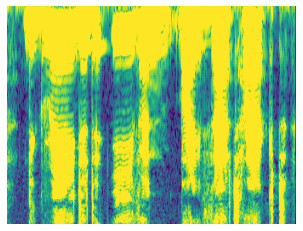

Spectrogram shape: (256, 340)
Encoded label:
[ 4  5  7 18  1  4  5  4 28  5 22  5 14 28  2 25 28 20  8  1 20 28  1  3
 20]
Decoded label:
degraded even by that act
[[  6.744778    3.9980268  -1.997946  ...  -9.018265   -4.197011
  -34.662243 ]
 [  4.2868924   1.624531   -4.579394  ... -11.278406   -6.0430737
  -36.087494 ]
 [  3.4287992   0.8285833  -5.5848327 ... -12.005877   -6.3292837
  -35.99301  ]
 ...
 [-25.317482  -25.85671   -20.267466  ... -30.84627   -21.48763
  -47.73717  ]
 [-28.584978  -27.857656  -26.789022  ... -26.24468   -26.660982
  -47.73717  ]
 [-23.288328  -21.283113  -24.231754  ... -23.714693  -24.957718
  -47.73717  ]]
-47.73717
32.26283


In [ ]:
label = data.transcription[data.index.min()]
audio_file = data.file_path[data.index.min()]

audio_data, samplerate = sf.read(audio_file)
ipd.display(ipd.Audio(data=audio_data, rate=samplerate))

spec, lab = encode_sample(
   audio_file, label)
print(spec.shape[-2])
spec = np.transpose(spec)

plt.imshow(spec, vmax=1)
plt.axis("off")
#plt.savefig(MEDIA_PATH+'mel_spec.png')
plt.show()
print(f"Spectrogram shape: {spec.shape}")

print(f"Encoded label:\n{lab}")
decoded_label = tf.strings.reduce_join(int_to_char(lab)).numpy().decode("utf-8")
print(f"Decoded label:\n{decoded_label}")
print(spec)
print(spec.min())
print(spec.max())


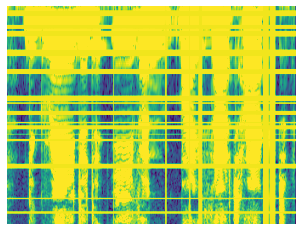

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([ 4,  5,  7, 18,  1,  4,  5,  4, 28,  5, 22,  5, 14, 28,  2, 25, 28,
       20,  8,  1, 20, 28,  1,  3, 20])>

In [ ]:
augspec, lab = augment_sample(audio_file, label)
augspec = np.transpose(augspec)
plt.imshow(augspec, vmax=1)
plt.axis("off")
plt.show()
lab

In [ ]:
test_batch_size = 1
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(data["file_path"]), list(data["transcription"]))
)
train_dataset = (
    train_dataset.map(augment_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(data_val["file_path"]), list(data_val["transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
# Define the test dataset
test_clean_dataset = tf.data.Dataset.from_tensor_slices(
    (list(data_test_clean["file_path"]), list(data_test_clean["transcription"]))
)
test_clean_dataset = (
    test_clean_dataset.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(test_batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
# Define the test-other dataset
test_other_dataset = tf.data.Dataset.from_tensor_slices(
    (list(data_test_other["file_path"]), list(data_test_other["transcription"]))
)
test_other_dataset = (
    test_other_dataset.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(test_batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
# for batch in train_dataset.take(1):
#     label_tokens = batch[1][5]
#     spec = batch[0][5]
#     print(spec.shape)
#     print(label_tokens)
#     label = tf.strings.reduce_join(int_to_char(label_tokens)).numpy().decode("utf-8")
#     print(label)
#     spec = np.transpose(spec)
#     plt.imshow(spec, vmax=1)
#     plt.axis("off")
#     plt.show()

## THE MODEL


In [ ]:
@tf.function(experimental_relax_shapes=True)
def ctc_decoding(y_pred, input_length):
    # From: https://github.com/keras-team/keras/blob/master/keras/backend.py
    input_shape = keras.backend.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.math.log(
        tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon()
    )
    input_length = tf.cast(input_length, tf.int32)

    (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
        inputs=y_pred, sequence_length=input_length, blank_index=0 # Default: num_classes - 1 , here="oov_token" = 0
        )

    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st)) # default_value=None (default), backend.py: default_value=-1 
    return (decoded_dense, log_prob)

In [ ]:
# Prepare a list of unigrams from the Librispeech vocabulary with 500k words:
unigrams_file = DATA_PATH+"kenlm-model/vocab-500000.txt"
with open(unigrams_file) as f:
    list_of_unigrams = [line.rstrip() for line in f]
    
# Let's have a look:    
list_of_unigrams[:10], len(list_of_unigrams)

(['the', 'and', 'of', 'to', 'a', 'in', 'i', 'he', 'that', 'was'], 500000)

In [ ]:
# Prepare a list of unigrams from the Librispeech vocabulary with 600k words:
unigrams_file = DATA_PATH+"kenlm-model/vocab-600000.txt"
with open(unigrams_file) as f:
    list_of_unigrams_600k = [line.rstrip() for line in f]
    
# Let's have a look:    
list_of_unigrams_600k[:10], len(list_of_unigrams_600k)

(['the', 'and', 'of', 'to', 'a', 'in', 'i', 'he', 'that', 'was'], 600000)

In [ ]:
def build_pyctcdecoder(MODEL_PATH=LM_MODEL_PATH+"lm_arpa5_500k_prune001.binary", UNIGRAMS=list_of_unigrams):
    decoder = build_ctcdecoder(
        labels=char_to_int.get_vocabulary(),
        kenlm_model_path = MODEL_PATH, # either .arpa or .bin file
        unigrams=UNIGRAMS, 
        alpha=0.9,  # 0.7 tuned on a val set, 0.931289039105002 0.5  LM Weight: 0.75
        beta=1.2,  # 1.0 tuned on a val set, 1.1834137581510284 1.0 # LM Usage Reward: 1.85
        #lm_score_boundary=False # default: True
        )
    return decoder
# # https://github.com/kensho-technologies/pyctcdecode
# # https://huggingface.co/edugp/kenlm/tree/main/wikipedia

hotwords_list = []

def ctc_decoding_lm(logits, decoder, beam_width=100, hotwords=hotwords_list):
    # ctc_decoder with use of Kenlm-model build on http://www.openslr.org/resources/11/librispeech-lm-norm.txt.gz (arpa_order=5, binary_type=trie)
    logits = np.squeeze(logits)
    text = decoder.decode(
        logits, 
        beam_width=beam_width,
        hotwords=hotwords,
        hotword_weight=10.0,
        )
    return text

In [ ]:
def ctc_loss(y_true, y_pred):
    # Compute the training-time loss value
    # based on: 
    # https://github.com/keras-team/keras/blob/253dc4604479b832dd254d0d348c0b3e7e53fe0f/keras/backend.py
    # with label_length and blank_index args to:
    # https://www.tensorflow.org/api_docs/python/tf/compat/v1/nn/ctc_loss_v2

    batch_len = tf.cast(tf.shape(y_true)[0], dtype=tf.int64)

    input_length = tf.cast(tf.shape(y_pred)[1], dtype=tf.int64)
    label_length = tf.cast(tf.shape(y_true)[1], dtype=tf.int64)

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)

    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    
    sparse_labels = tf.cast(keras.backend.ctc_label_dense_to_sparse(y_true, label_length), tf.int32)
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon() )

    loss = tf.expand_dims( 
            tf.nn.ctc_loss(
                labels=sparse_labels, 
                logits=y_pred, 
                label_length=label_length, 
                logit_length=input_length, 
                blank_index=0
                ), 
                1
            )

    return loss

In [ ]:
K.clear_session()

In [ ]:
get_custom_objects().update({'ctc_loss': ctc_loss})

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=512):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1),
                       name="expand_dim")(input_spectrogram)
                       
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    #x = layers.Dropout(rate=0.2)(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification layer
    output = layers.Dense(units=output_dim, activation="softmax", dtype=tf.float32)(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-7) # 1e-7
    #Schedule: 0.0002 (2e-4), 0.0001 (1e-4), 0.00008 (8e-5), 0.00005 (5e-5), 0.00003 (3e-5), 0.00001 (1e-5), 0.000007 (7e-6), 0.000005 (5e-6), 0.000003 (3e-6), 0.000001 (1e-6), 8e-7 0.0000008
    # alternative:
    #opt = keras.optimizers.SGD(learning_rate=0.0003, decay=1e-5, momentum=0.9, nesterov=True, clipnorm=5)

    # Compile the model and return
    model.compile(optimizer=opt, loss=ctc_loss)
    print(f"Optimizer: {tf.keras.optimizers.get(opt)} with learning_rate: {K.eval(model.optimizer.learning_rate):.6f}")
    return model

# Get the model
model = build_model(
   input_dim=n_mels,
   output_dim=char_to_int.vocabulary_size(),
   rnn_units=512,
)


### Training & Evaluating

In [ ]:
line = "-" * 110
double_line = "=" * 110

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    #results = keras.backend.ctc_decode(
    #    pred, input_length=input_len, greedy=True)[0][0]
    results = ctc_decoding(pred, input_length=input_len)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(
            int_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.epoch_loss = {}
        self.epoch_val_loss = {}
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
        self.train_loss_file = open(MODEL_PATH+MODEL_NAME+"_train_loss.csv", 'a')
        # datetime object containing current date and time
        now = datetime.now(tz=pytz.timezone("Europe/Berlin"))
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S") # dd/mm/YY H:M:S #
        
        # A csv-file to store training history data after each epoch for evaluation:
        history_file = MODEL_PATH+MODEL_NAME+"_history.csv"
        with open(history_file, 'a') as hf:
            if os.stat(history_file).st_size == 0:
                hf.write("begin;end;epoch;loss;val_loss;wer;learning_rate\n")
            hf.write(f"{dt_string};")

    def on_train_batch_end(self, batch: int, logs={}):
        self.train_loss_file.write(f"{str(self.epoch+1)};{str(batch+1)};{str(logs.get('loss'))}\n")

    def on_epoch_end(self, epoch: int, logs={}):
        model.save(MODEL_PATH+MODEL_NAME+'_last.h5')
        self.train_loss_file.close()
        predictions = []
        transcriptions = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(int_to_char(
                        label)).numpy().decode("utf-8")
                )
                transcriptions.append(label)
        wer_score = wer(transcriptions, predictions)
        cer_score = cer(transcriptions, predictions)
        print("\n")
        print(double_line)
        print(f"Word Error Rate: {wer_score:.4f}")
        print(f"Character Error Rate: {cer_score:.4f}")
        print(double_line)

        for i in np.random.randint(0, len(predictions), 2):
            print(f"Transcription: {transcriptions[i]}")
            print(f"Prediction:    {predictions[i]}")
            print(line)

        # datetime object containing current date and time 
        now = datetime.now(tz=pytz.timezone("Europe/Berlin"))
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S") # dd/mm/YY H:M:S #
        
        # Write end-time, epoch-number, loss, val_loss and wer-score to the history-file after each epoch for evaluation:
        history_file = MODEL_PATH+MODEL_NAME+"_history2.csv"
        with open(history_file, 'a') as hf:
            hf.write(f"{dt_string};{str(epoch+1)};{str(logs.get('loss'))};{str(logs.get('val_loss'))};{str(wer_score)};{K.eval(model.optimizer.learning_rate):.7f}\n")


In [ ]:
MODEL_NAME = 'RNN_ctc2_6000_29out'
model = keras.models.load_model(MODEL_PATH+"RNN_ctc2_6000_29out_vl22.12.h5")

#model.load_weights(filepath=MODEL_PATH + "RNN_ctc2_6000_29out_vl22.12.h5")
#model.save(MODEL_PATH+MODEL_NAME+'_small.h5')

print(f"Learning rate: {K.eval(model.optimizer.learning_rate):.7f}")
model.summary(line_length=110)


Learning rate: 0.0000001
Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 256)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 256, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 128, 32)                       14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 128

In [ ]:
epochs = 4 # colab maximum 24 hours
# Callback function to check transcription on the validation data.
validation_callback = CallbackEval(validation_dataset)

# Callbacks:
mc = ModelCheckpoint(filepath=MODEL_PATH+MODEL_NAME+".h5", verbose=1, save_best_only=True)
es = EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, mc, es]
)

In [ ]:
history_df = pd.read_csv(MODEL_PATH+MODEL_NAME+"_history.csv", sep=";")
history_df

,begin,end,epoch,loss,val_loss,wer,learning_rate
0,06/07/2022 08:55:23,06/07/2022 14:53:58,1,201.901749,101.260735,0.503594,2.000000e-04
1,06/07/2022 14:54:05,06/07/2022 20:11:24,2,105.764557,74.306465,0.377089,2.000000e-04
2,06/07/2022 20:11:30,07/07/2022 01:21:57,3,85.137947,63.813541,0.325950,2.000000e-04
3,11/07/2022 22:57:21,12/07/2022 04:47:06,1,69.969635,50.319260,0.271220,1.000000e-04
4,12/07/2022 04:47:41,12/07/2022 10:03:16,2,64.272133,48.044685,0.259819,1.000000e-04
...,...,...,...,...,...,...,...
99,26/08/2022 06:25:39,26/08/2022 11:56:14,4,37.288170,14.284861,0.234181,1.000000e-07
100,27/08/2022 08:17:25,27/08/2022 13:56:39,1,31.081339,13.681232,0.229377,1.000000e-07
101,27/08/2022 13:56:40,27/08/2022 18:45:18,2,31.011263,13.845669,0.230626,1.000000e-07
102,29/08/2022 09:33:13,29/08/2022 15:17:26,1,29.176054,22.125185,0.225536,1.000000e-07


In [ ]:
# Plot history with plotly subplots:
fig = make_subplots(specs=[[{"secondary_y": True, "type": "xy"}]])

fig.add_trace(go.Scatter(y=history_df["loss"], x=history_df.index, name="loss"), secondary_y=False)
fig.add_trace(go.Scatter(y=history_df["val_loss"], x=history_df.index, name="val_loss"), secondary_y=False)
fig.add_trace(go.Scatter(y=history_df["wer"]*100, x=history_df.index, name="wer"), secondary_y=True) # , line_color='#ffe476'
# Layout:
fig.update_layout(title_text="Loss, Validation Loss and Word Error Rate (wer)", template='plotly_dark')
fig.update_layout(title_text="<b>Loss, Validation Loss and Word Error Rate (wer)</b>", template='plotly_dark')
# 1 x-axis:
fig.update_xaxes(title_text="epochs", dtick=[len(history_df.index)])
# 2 y-axes:
fig.update_yaxes(title_text="loss and val_loss", secondary_y=False, range=[0,250])
fig.update_yaxes(title_text="word error rate (percent)", secondary_y=True, range=[0,100])

fig.show()
# Save as:
#fig.write_html(MODEL_PATH+MODEL_NAME+"_history.html", include_plotlyjs=True)
#fig.write_image(MODEL_PATH+MODEL_NAME+"_history.png", format='png', scale=1, width=1200, height=600)
#fig.write_image(MODEL_PATH+MODEL_NAME+"_history.svg", format='svg', scale=1, width=900, height=450)

## Inference

### Testing ctc-decoding (greedy) on CLEAN test data 

In [ ]:
predictions = []
transcriptions = []

for batch in tqdm(test_clean_dataset):
    X, y = batch

# Get the prediction from the model and decode with ctc-decode (greedy)
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

# Decode back the true transcriptions from the encoded batch-data:
    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

# Calculate the Word Error Rate & Character Error Rate for the results:
wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)

# Print 5 random results for comparison:
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(line)


  0%|          | 0/2620 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.1080
Character Error Rate: 0.0331
--------------------------------------------------------------------------------------------------------------
Transcriptions: by the beard of odin i cried you have taken our joke like a man
Prediction:     by the beard of od and i cried you have taken our jope like a man
--------------------------------------------------------------------------------------------------------------
Transcriptions: the south she had not thought of seriously and yet knowing of its delightful hospitality and mild climate she was not averse to charleston or new orleans
Prediction:     the south she had not thought of seriously and yet knowing of its delightful hospitality and mild climate she was not averse to charleston or new orlands
--------------------------------------------------------------------------------------------------------------
T

### Testing ctc-decoding with language model (beam search) on CLEAN test data 

*   language model: 3gram, 400k words, prune 01
*   unigram_list: 500k words
*   beam_width: 50

In [ ]:
lm_model = "3gram_400k_p01.bin"
# create a decoder-object (A trie is created from list_of_unigrams)
decoder = build_pyctcdecoder(LM_MODEL_PATH + lm_model)

predictions = []
transcriptions = []

for batch in tqdm(test_clean_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 50)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2620 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.0639
Character Error Rate: 0.0238
--------------------------------------------------------------------------------------------------------------
Transcriptions: where the waves for an instant sank they came closer but not quite within grasping reach
Prediction:     where the waves for an instant sank they came closer but not quite within grasping reach
Transcriptions: let us begin with that his commentary on galatians
Prediction:     let us begin with that his commentary on galatians
Transcriptions: this is our last feast with you i said
Prediction:     this is our last feast with you i said
Transcriptions: her bearing was graceful and animated she led her son by the hand and before her walked two maids with wax lights and silver candlesticks
Prediction:     her bearing was graceful and animated she led her son by the hand and before her walked two maids wit

*   language model: 4gram, 500k words, prune 01
*   unigram_list: 500k words
*   beam_width: 50

In [ ]:
lm_model = "4gram_500k_p01.bin"
predictions = []
transcriptions = []
decoder = build_pyctcdecoder(LM_MODEL_PATH+lm_model)

for batch in tqdm(test_clean_dataset):
    X, y = batch

    batch_predictions = model.predict(X)


    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 50)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2620 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.0630
Character Error Rate: 0.0235
--------------------------------------------------------------------------------------------------------------
Transcriptions: you resemble me rachel you are fearless and inflexible and generous
Prediction:     you resemble me rachel you are fearless and inflexible and generous
Transcriptions: just then leocadia came to herself and embracing the cross seemed changed into a sea of tears and the gentleman remained in utter bewilderment until his wife had repeated to him from beginning to end leocadia's whole story and he believed it through the blessed dispensation of heaven which had confirmed it by so many convincing testimonies
Prediction:     just then leocadia came to herself and embracing the cross seemed changed into a sea of tears and the gentlemen remaining in utter bewilderment until his wife had repeated to him from

*   language model: 5gram, 500k words, prune 01
*   unigram_list: 500k words
*   beam_width: 50

In [ ]:
lm_model = "5gram_500k_p01.bin"
decoder = build_pyctcdecoder(LM_MODEL_PATH+lm_model)

predictions = []
transcriptions = []

for batch in tqdm(test_clean_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 50)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2620 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.0632
Character Error Rate: 0.0235
--------------------------------------------------------------------------------------------------------------
Transcriptions: next came olive's turn to help in the ceremonies
Prediction:     next came olives turned to help in the ceremonies
Transcriptions: that is comparatively nothing
Prediction:     that he is comparatively nothing
Transcriptions: i get tired of seeing men and horses going up and down up and down
Prediction:     i get tired of seeing men and horses going up and down up and down
Transcriptions: yes so they said but that would i think have been worse
Prediction:     yes so they said but that would i think have been worse
Transcriptions: and these shall follow your thralls in the same way
Prediction:     and these shall follow your thralls in the same way


### Testing ctc-decoding (greedy) on OTHER test data 

In [ ]:
predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

# Get the prediction from the model and decode with ctc-decode (greedy)
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

# Decode back the true transcriptions from the encoded batch-data:
    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

# Calculate the Word Error Rate & Character Error Rate for the results:
wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)

# Print 5 random results for comparison:
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(line)


  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.2732
Character Error Rate: 0.1085
--------------------------------------------------------------------------------------------------------------
Transcriptions: why i stood so said the tiger jumping into the cage and my head was on this side
Prediction:     wy i stood so said tetager jumping into the cage in my head was on this side
--------------------------------------------------------------------------------------------------------------
Transcriptions: she was waitin for the wood to boil the kettle when i come out mother
Prediction:     she was baton for the watd to by the cattle wen i come out mother
--------------------------------------------------------------------------------------------------------------
Transcriptions: reverend mother i did not say more often than what i said more often
Prediction:     rivern mother i did not say more often than 

### Testing ctc-decoding with language model (beam search) on OTHER test data

*   language model: 3gram, 400k words, prune 01
*   unigram_list: 600k words
*   beam_width: 200

In [ ]:
lm_model = "3gram_400k_p01.bin"
# create a decoder-object (A trie is created from list_of_unigrams)
decoder = build_pyctcdecoder(LM_MODEL_PATH + lm_model, list_of_unigrams_600k)

predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 200)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.1882
Character Error Rate: 0.0913
--------------------------------------------------------------------------------------------------------------
Transcriptions: the popular song of the moment replied the agitator after a moment's reflection
Prediction:     the popular song of the moment replied the agitator after a moment's reflection
Transcriptions: never mind about that let me out of this place
Prediction:     never mind about that let me out of this place
Transcriptions: every increase in the army of one state with the aim of self defense against its subjects becomes a source of danger for neighboring states and calls for a similar increase in their armies
Prediction:     every increase in the army of one state with the aim of self defence against its subjects becomes a sort of danger for neighboring states and calls for a similar increase in their armies

*   language model: 5gram, 500k words, prune 0001
*   unigram_list: 600k words
*   beam_width: 200

In [ ]:
lm_model = "lm_arpa5_500k_prune0001.binary"
# create a decoder-object (A trie is created from list_of_unigrams)
decoder = build_pyctcdecoder(LM_MODEL_PATH + lm_model, list_of_unigrams_600k)

predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 200)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.1833
Character Error Rate: 0.0889
--------------------------------------------------------------------------------------------------------------
Transcriptions: he had to sleep with it pillowed on my breast jim being also crippled with a wound in his shoulder and we could not get much sleep
Prediction:     he had a sleep with a pillow on my breast jim being also cripple with a wound in his shoulder and we could not get much sleep
Transcriptions: on the twenty seventh occurred the debate on the land question which revealed the differences between the agrarian programme of the bolsheviki and the left socialist revolutionaries
Prediction:     on the twenty seventh a cord the debate on the land question we should revertayfrancis between the agrarian program of the bolsheviki and the left socialist revolushnis
Transcriptions: well
Prediction:     well
Transcripti

*   language model: 4gram, 500k words, prune 001
*   unigram_list: 600k words
*   beam_width: 200

In [ ]:
lm_model = "4gram_500k_p001.bin"
# create a decoder-object (A trie is created from list_of_unigrams)
decoder = build_pyctcdecoder(LM_MODEL_PATH + lm_model, UNIGRAMS=list_of_unigrams_600k)

predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 200)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.1863
Character Error Rate: 0.0908
--------------------------------------------------------------------------------------------------------------
Transcriptions: shut and bolted said the brahman
Prediction:     shut and voided said de brami
Transcriptions: you will remove your bell
Prediction:     you will remove your belt
Transcriptions: he perceived that it was no good talking to the old man and that the principal person in the house was the mother
Prediction:     he received that it is no good talking to the old man and that the principal person in the hose as the mother
Transcriptions: friday we moved toward waterville and friday night we camped between elysian and german lake
Prediction:     friday we move toward water bill and friday night we can't between elysian and german lake
Transcriptions: to have himself nailed up in a case and carried off like a

*   language model: 4gram, 500k words, prune 001
*   unigram_list: 500k words
*   beam_width: 200

In [ ]:
lm_model = "4gram_500k_p001.bin"
# create a decoder-object (A trie is created from list_of_unigrams)
decoder = build_pyctcdecoder(LM_MODEL_PATH + lm_model, UNIGRAMS=list_of_unigrams)

predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 200)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.1864
Character Error Rate: 0.0909
--------------------------------------------------------------------------------------------------------------
Transcriptions: it's tom sawyer
Prediction:     is tom sae
Transcriptions: martin the eleventh general of the carthusians gave to his order this device stat crux dum volvitur orbis
Prediction:     martin the eleventh general of the contusions gave to his order this device statcrew doomful which her orbis
Transcriptions: git aboard says the king
Prediction:     getaboard says the king
Transcriptions: what would you make of me and the children to be sure that worry her to death between them
Prediction:     what did you make of me and the children to be sure that were you hurt this between them
Transcriptions: perhaps not admitted colonel ashley
Prediction:     perhaps not admitted colonel ashley


*   language model: 5gram, 500k words, prune 0001
*   unigram_list: 600k words
*   beam_width: 400

In [ ]:
lm_model = "lm_arpa5_500k_prune0001.binary"
# create a decoder-object (A trie is created from list_of_unigrams)
decoder = build_pyctcdecoder(LM_MODEL_PATH + lm_model, list_of_unigrams_600k)

predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 400)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.1833
Character Error Rate: 0.0890
--------------------------------------------------------------------------------------------------------------
Transcriptions: don't you think he means to
Prediction:     don't you think he means to
Transcriptions: so they always acquit and then a man goes in the night with a hundred masked cowards at his back and lynches the rascal
Prediction:     so they always equip and then a man goes in the night with a hundred mast cowards at his back and lunches the rascal
Transcriptions: so there he sat with his head on her lap taking his ease the livelong day
Prediction:     so there he sat with his head on her laugh taking his ease the livelong day
Transcriptions: no one doubts the right of the monastery to sepulture
Prediction:     no one doubts the right of the moessary to sepulture
Transcriptions: the royal lady had inquired abo

*   language model: 3gram, 400k words, prune 01
*   unigram_list: 500k words
*   beam_width: 50

In [ ]:
lm_model = "3gram_400k_p01.bin"
decoder = build_pyctcdecoder(LM_MODEL_PATH+lm_model)

predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 50)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.1970
Character Error Rate: 0.0948
--------------------------------------------------------------------------------------------------------------
Transcriptions: lend us the instruments said the chief organiser
Prediction:     lanes the instruments said a chief organiser
Transcriptions: don't know as he has been seen about here do you said gurr looking at her searchingly no sir
Prediction:     don't know as he has been seen about her to you said girl looking at her certainly no sir
Transcriptions: who nails up the coffin i do
Prediction:     who nails up the coffin i do
Transcriptions: it would be a good thing to have two men for it
Prediction:     it would be a good thing to have two men for it
Transcriptions: i must see her myself early in the morning and i am quite sure that nothing will satisfy miss lauderdale except a very ample apology and a full explan

*   language model: 5gram, 500k words, prune 01
*   unigram_list: 500k
*   beam_width: 400

In [ ]:
lm_model = "5gram_500k_p01.bin"
decoder = build_pyctcdecoder(LM_MODEL_PATH + lm_model)

predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 400)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.1854
Character Error Rate: 0.0899
--------------------------------------------------------------------------------------------------------------
Transcriptions: and therefore the oppression of the oppressed always goes on growing up to the furthest limit beyond which it cannot go without killing the goose with the golden eggs
Prediction:     and therefore the oppression of the oppressed always goes on growing up the furthest lemon beyond which it cannot go without killing the goose with the gold nic
Transcriptions: let them sing another psalm said the curate
Prediction:     them thumping and now the samsa the curate
Transcriptions: good evening colonel he called genially will you join me in a welsh rabbit
Prediction:     good evening colonel he called gaily will you join me in a well rabbit
Transcriptions: would that interfere with jakey's getting the job si

*   language model: 5gram, 500k words, prune 01
*   unigram_list: None
*   beam_width: 50

In [ ]:
lm_model = "5gram_500k_p01.bin"
decoder = build_pyctcdecoder(MODEL_PATH=LM_MODEL_PATH + lm_model, UNIGRAMS=None)
predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 50)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.2197
Character Error Rate: 0.1010
--------------------------------------------------------------------------------------------------------------
Transcriptions: take the meat of one large crab scraping out all of the fat from the shell
Prediction:     take the meat of one large capscopingeur all the fat from the shop
Transcriptions: they swarmed up in front of sherburn's palings as thick as they could jam together and you couldn't hear yourself think for the noise
Prediction:     they swarmed up and fronaservern's palings as thick as they could jam together and you couldn't hear yourself think for the noise
Transcriptions: the black knight was soon engaged in desperate combat with the norman chief and the vaulted roof of the hall rung with their furious blows
Prediction:     the black night was soon engaged in dasperacomebat with the norman chief and devoted

*   language model: 5gram, 500k words, prune 001
*   unigram_list: 600k words
*   beam_width: 400

In [ ]:
lm_model = "5gram_500k_p001.bin"
# create a decoder-object (A trie is created from list_of_unigrams)
decoder = build_pyctcdecoder(LM_MODEL_PATH + lm_model, list_of_unigrams_600k)

predictions = []
transcriptions = []

for batch in tqdm(test_other_dataset):
    X, y = batch

    batch_predictions = model.predict(X)

    for pred in batch_predictions:
        pred = ctc_decoding_lm(pred, decoder, 400)
        predictions.append(pred)

    for label in y:
        label = tf.strings.reduce_join(
            int_to_char(label)).numpy().decode("utf-8")
        transcriptions.append(label)

wer_score = wer(transcriptions, predictions)
cer_score = cer(transcriptions, predictions)
print(line)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Character Error Rate: {cer_score:.4f}")
print(line)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Transcriptions: {transcriptions[i]}")
    print(f"Prediction:     {predictions[i]}")
    print(double_line)

  0%|          | 0/2939 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------
Word Error Rate: 0.1846
Character Error Rate: 0.0897
--------------------------------------------------------------------------------------------------------------
Transcriptions: i have missed four fits and had but five and have recovered so much strength as made me venture to meet your letter on wednesday a mile from home
Prediction:     i have missed four fits and have had but five and have recovered so much strength as made me venture to meet your letter on wednesday a mile from home
Transcriptions: bruce gordon grimaced i've got a yellow ticket from security
Prediction:     briscordongrimmised i've got a yellow ticket from security
Transcriptions: sparrows will not eat unless you bob them on the tail nor can i drink if i be not fairly spoke to
Prediction:     sparrows when i eat unless you bobbed them on the tale nor can i drink if i be not fairly spoke to
Transcriptions:

In [ ]:
@tf.function(experimental_relax_shapes=True)
def encode_audio(file, sr=16000, n_fft=2024, stride=128, window=256, n_mels=n_mels, rate_in=22500):
    if file.split(".")[-1] == "flac":
        audio = tf.io.read_file(file)
        audio = tfio.audio.decode_flac(audio, dtype=tf.int16)
        
        audio = tfio.audio.resample(audio, rate_in, rate_out=sr, name=None)
        
        audio = audio / tf.reduce_max(audio)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.cast(audio, tf.float32)
        spectrogram = tfio.audio.spectrogram(audio, nfft=n_fft, window=window, stride=stride)
        mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sr, mels=n_mels, fmin=fmin, fmax=fmax)
        dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
        return dbscale_mel_spectrogram
    else:
        audio = tf.io.read_file(file)
        audio = tfio.audio.decode_wav(audio, dtype=tf.int16)

        audio = tfio.audio.resample(audio, rate_in, rate_out=sr, name=None)
        
        audio = audio / tf.reduce_max(audio)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.cast(audio, tf.float32)
        spectrogram = tfio.audio.spectrogram(audio, nfft=n_fft, window=window, stride=stride)
        mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sr, mels=n_mels, fmin=fmin, fmax=fmax)
        dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
        return dbscale_mel_spectrogram

def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    result = ctc_decoding(pred, input_length=input_len)[0][0]
    result = tf.strings.reduce_join(int_to_char(result)).numpy().decode("utf-8")
    return result


In [ ]:
my_file = RECORDINGS_PATH+"chunk6.wav"

#my_file = RECORDINGS_PATH+"recording.wav"
print(my_file)

data, samplerate = sf.read(my_file)
recording = encode_audio(my_file, sr=16000, rate_in=samplerate)
recording = np.expand_dims(recording, axis=0)
print(recording.shape)


/content/drive/MyDrive/LibriSpeech/my_recordings/chunk6.wav


(1, 3335, 256)


In [ ]:
ipd.Audio(data=data, rate=samplerate)

In [ ]:
time_before = time()
pred = model.predict(recording)
result = decode_predictions(pred)
time_after = time()
total_time = time_after - time_before
print(total_time)
print(result)


0.4796762466430664
and there certainly in certainly about how bad those effectill be but they will be extremely bad i asked the top scientison o several times to we really have to get down to near zero can't we just in a cutten half or quarter an answer is that until we get near deero the temperature will continued trise and to that's that's be challenge it's very different than saing inaword twelve tut high trock tindt get under a tenfort bridge n we can dissort u


In [ ]:
#lm_model = "3gram_400k_p01.bin"
lm_model = "5gram_500k_p001.bin" 
#lm_model = "lm_arpa5_500k_prune0001.binary" 
#lm_model = "lm_arpa6_600k_prune001.binary"
decoder = build_pyctcdecoder(LM_MODEL_PATH+lm_model, list_of_unigrams_600k)

In [ ]:
hotwords_list = ["natural", "ecosystem", "eco", "systems", "weather", "temperature", "effects", "climate", "co", "two"]

time_before = time()
pred = model.predict(recording)
result = ctc_decoding_lm(pred, decoder, 200, hotwords_list)

time_after = time()
total_time = time_after - time_before
print(total_time)
print(result)


1.003861427307129
and there certainly in certainly about how bad those effects will be but they will be extremely bad i asked the top sintians several times do we really have to get down to near zero can't we just in a cut in half or quarter an answer is that until we get near de zero the temperature will continue to rise and to that's that's be challenge it's very different then saying in a word twelve foot high truck find get under a tenfotbridgenwe can desert
